# TFM - Predicción potenciales compradores de un ecommerce

Evolución del notebook *Modelo_4- XGBoost.ipynb* unicamente aplicando a **personas físicas**

------------------------------------

------------------

### 1.1 Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier

from xgboost import XGBClassifier

from collections import Counter

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

------------------

### 1.2 Variables globales

In [2]:
LABELS = ["No_Cliente","Cliente"]

------------------

### 1.3 Funciones

In [3]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = "d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

------------------------------------

------------------

A continuación comenzamos leyendo los ficheros que hemos tratado, limpiado y analizado en los procesos anteriores.

Se realizará un análisis sencillo de la estructura y una visualización de varias muestras. 

Además someteremos las variables categóricas a variables *dummies*, de forma que que podamos introducirlas ennuestro modelo.

### 2.1 Lectura de Fichero

In [4]:
df = pd.read_csv('Data/dataset_model_corr.txt', sep = ';', encoding = 'ISO-8859-1')

In [5]:
df.shape

(406267, 26)

In [6]:
df.head(3)

,TIPOUSUARIO,FECHA_REGISTRO_WEEKDAY,FECHA_REGISTRO_MONTH,CANAL_REGISTRO,TIPOEMAIL,BONDAD_EMAIL,TIPO_TELF,IP_CONTINENTE,IP_COUNTRY_PIB,USU_TIPO,USU_TAMANIO,USU_ESTADO,USU_SECTOR_ECONOMICO,1A_DESCGRUPOPROD,1A_EMPCONSUL_EST,1A_EMPCONSUL_SECTOR,IPCASOS,IP_COUNTRY_IDH_NUM,USU_DEPART_DEN_POB,USU_DEPART_IDH,1A_EMPCONSUL_PROV_DENS,1A_EMPCONSUL_PROV_IDH,FICH_PROMO_TOT,PERF_PROMO_TOT,IND_ALTA,IND_CLIENTE
0,PF,1,10,3,GOOHOTYAHMAIL,0,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,NoApl,NoApl,NoApl,NoApl,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,-1.00,-1.000,47.92,0.782,0,1,0,0
1,PJ,1,5,3,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,PQ,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,SD,1,0.767,306.38,0.832,47.92,0.782,0,1,0,0
2,PJ,2,9,7,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,MC,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,815.17,0.835,4438.75,0.904,0,1,0,0


------------------

### 2.2 Variables dummies

In [7]:
ohe_columns = ['TIPOUSUARIO','FECHA_REGISTRO_WEEKDAY','FECHA_REGISTRO_MONTH','CANAL_REGISTRO','TIPOEMAIL','TIPO_TELF','IP_CONTINENTE','IP_COUNTRY_PIB','USU_TIPO',
               'USU_TAMANIO','USU_ESTADO','USU_SECTOR_ECONOMICO','1A_DESCGRUPOPROD','1A_EMPCONSUL_EST','1A_EMPCONSUL_SECTOR']

In [8]:
final_df = pd.get_dummies(df, columns = ohe_columns)

**Columnas para la predicción**

In [9]:
columnas = ['TIPOUSUARIO_PF','FECHA_REGISTRO_WEEKDAY_0','FECHA_REGISTRO_WEEKDAY_1', 'FECHA_REGISTRO_WEEKDAY_2','FECHA_REGISTRO_WEEKDAY_3', 
            'FECHA_REGISTRO_WEEKDAY_4','FECHA_REGISTRO_WEEKDAY_5', 'FECHA_REGISTRO_WEEKDAY_6','FECHA_REGISTRO_MONTH_1', 'FECHA_REGISTRO_MONTH_2',
            'FECHA_REGISTRO_MONTH_3', 'FECHA_REGISTRO_MONTH_4','FECHA_REGISTRO_MONTH_5', 'FECHA_REGISTRO_MONTH_6','FECHA_REGISTRO_MONTH_7', 'FECHA_REGISTRO_MONTH_8',
            'FECHA_REGISTRO_MONTH_9', 'FECHA_REGISTRO_MONTH_10','FECHA_REGISTRO_MONTH_11', 'FECHA_REGISTRO_MONTH_12','CANAL_REGISTRO_1', 'CANAL_REGISTRO_2', 'CANAL_REGISTRO_3',
            'CANAL_REGISTRO_4', 'CANAL_REGISTRO_5', 'CANAL_REGISTRO_6', 'CANAL_REGISTRO_7', 'CANAL_REGISTRO_8', 'CANAL_REGISTRO_9','TIPOEMAIL_ADMINISTRACION','TIPOEMAIL_CORPORATIVO',
            'TIPOEMAIL_DOCENTE','TIPOEMAIL_GOOHOTYAHMAIL','TIPOEMAIL_SINCLASIFICAR','TIPOEMAIL_TEMPORAL','BONDAD_EMAIL','IPCASOS','TIPO_TELF_EXTRANJERO',
            'TIPO_TELF_MOVIL', 'TIPO_TELF_NO_PUBLICO','IP_CONTINENTE_AFRICA','IP_CONTINENTE_AMERICA_NORTE','IP_CONTINENTE_AMERICA_SUR','IP_CONTINENTE_ASIA','IP_CONTINENTE_EUROPA',
            'IP_CONTINENTE_NI','IP_CONTINENTE_OCEANNIA', 'IP_COUNTRY_PIB_Ingreso alto','IP_COUNTRY_PIB_Ingreso mediano alto','IP_COUNTRY_PIB_NI',
            'IP_COUNTRY_PIB_Países de ingreso mediano bajo','IP_COUNTRY_IDH_NUM','FICH_PROMO_TOT','PERF_PROMO_TOT','1A_EMPCONSUL_EST_ACTIVA', 
            '1A_EMPCONSUL_EST_INACTIVA', '1A_DESCGRUPOPROD_FICH_PROMO', '1A_DESCGRUPOPROD_PERF_PROMO', '1A_DESCGRUPOPROD_RES_PAGO', '1A_EMPCONSUL_EST_NI', 
            '1A_EMPCONSUL_EST_REESTRUCTURACION', '1A_EMPCONSUL_EST_RELACION_CLINTON', '1A_EMPCONSUL_SECTOR_CUATERNARIO', '1A_EMPCONSUL_SECTOR_PRIMARIO', '1A_EMPCONSUL_SECTOR_QUINARIO',
            '1A_EMPCONSUL_SECTOR_SD', '1A_EMPCONSUL_SECTOR_SECUNDARIO', '1A_EMPCONSUL_SECTOR_TERCIARIO']

-----------------

------------------

### 3.1 Analisis desbalanceo

In [10]:
final_df.shape

(406267, 100)

In [11]:
pd.value_counts(final_df.loc[final_df['TIPOUSUARIO_PF'] == 1, 'IND_CLIENTE'], sort = True)

0    296938
1      3831
Name: IND_CLIENTE, dtype: int64

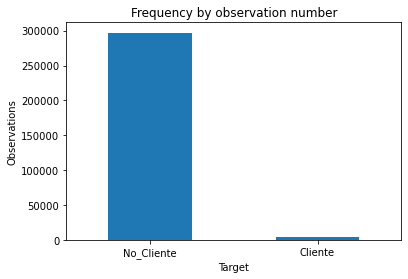

In [12]:
count_classes = pd.value_counts(final_df.loc[final_df['TIPOUSUARIO_PF'] == 1, 'IND_CLIENTE'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Target")
plt.ylabel("Observations");

In [13]:
print('Los clientes suponen un % del total: ', ((3831/(len(final_df.loc[final_df['TIPOUSUARIO_PF'] == 1])))*100))

Los clientes suponen un % del total:  1.2737349926355441


**Podemos ver un claro desbalanceo donde los clientes no suponen más del 3% de las observaciones**

------------------

------------------

### 4. Creación del Modelo

#### 4.1 Dividimos el set entre features y label

In [14]:
final_df_PF = final_df.loc[final_df['TIPOUSUARIO_PF'] == 1]

In [15]:
features = final_df_PF[columnas]
labels = final_df_PF['IND_CLIENTE']

In [16]:
features.shape

(300769, 68)

In [17]:
labels.shape

(300769,)

------------------

#### 4.2 Creamos set de entrenamiento y test

In [18]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [19]:
train_x.shape

(210538, 68)

In [20]:
test_x.shape

(90231, 68)

In [21]:
train_y.shape

(210538,)

In [22]:
test_y.shape

(90231,)

--------------

--------------

#### 4.3 Modelo 1 - Baseline

Nuestro modelo Base, tendrá los parámetros obtenidos como mejores anteriormente.

**Aplicamos los mejores hiperparámetros obtenidos**

In [23]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [24]:
clf.fit(train_x, train_y)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

Observamos los resultados del modelo

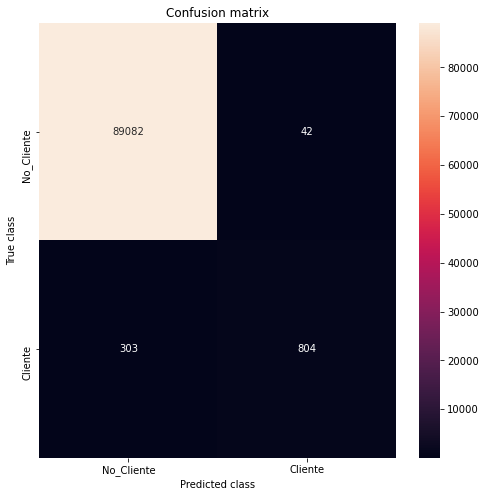

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89124
           1       0.95      0.73      0.82      1107

    accuracy                           1.00     90231
   macro avg       0.97      0.86      0.91     90231
weighted avg       1.00      1.00      1.00     90231



In [25]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [26]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [27]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
BONDAD_EMAIL,9.282849
1A_DESCGRUPOPROD_RES_PAGO,8.312246
FICH_PROMO_TOT,3.632363
IP_COUNTRY_PIB_Ingreso mediano alto,3.558057
CANAL_REGISTRO_9,3.192086
TIPOEMAIL_TEMPORAL,2.868239
IP_CONTINENTE_AMERICA_NORTE,2.735240
PERF_PROMO_TOT,2.184484
IP_COUNTRY_PIB_Ingreso alto,1.993420
FECHA_REGISTRO_MONTH_11,1.771329


In [28]:
feature_importances[feature_importances['important'] > 0.01].shape

(46, 1)

------

------

------

#### 4.4 Modelo - Aplicando técnicas sobre el desbalanceo

**Estrategias para el manejo de Datos Desbalanceados**

##### **4.4.1 Subsampling en la clase mayoritaria**

**RandomUnderSampler**

In [29]:
us = RandomUnderSampler(sampling_strategy = 'majority', random_state = 123)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 207814, 1: 2724})
Distribution after resampling Counter({0: 2724, 1: 2724})


In [30]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [31]:
clf.fit(X_train_res, y_train_res)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

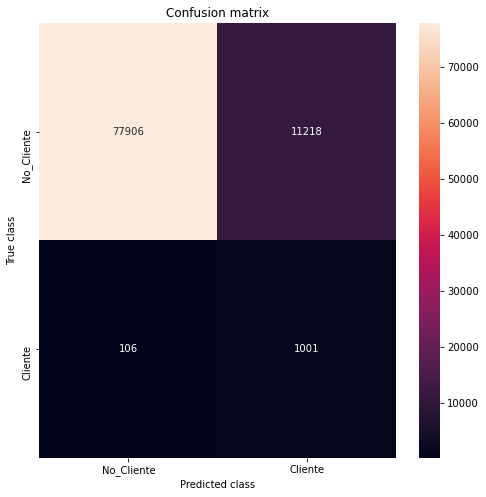

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     89124
           1       0.08      0.90      0.15      1107

    accuracy                           0.87     90231
   macro avg       0.54      0.89      0.54     90231
weighted avg       0.99      0.87      0.92     90231



In [32]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [33]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [34]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
BONDAD_EMAIL,18.368153
FICH_PROMO_TOT,8.788705
TIPOEMAIL_TEMPORAL,4.353050
IP_COUNTRY_PIB_Ingreso mediano alto,3.349658
1A_EMPCONSUL_EST_ACTIVA,2.032518
1A_DESCGRUPOPROD_RES_PAGO,1.930477
PERF_PROMO_TOT,1.800203
IP_CONTINENTE_AMERICA_SUR,1.740534
1A_DESCGRUPOPROD_PERF_PROMO,1.716992
IP_CONTINENTE_EUROPA,1.548938


In [35]:
feature_importances[feature_importances['important'] > 0.01].shape

(40, 1)

------

##### **4.4.2 Oversampling en la clase minoritaria**

**SMOTE**

In [36]:
os =  SMOTE(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

In [37]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 207814, 1: 2724})
Distribution labels after resampling Counter({0: 207814, 1: 207814})


In [38]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [39]:
clf.fit(X_train_res, y_train_res)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

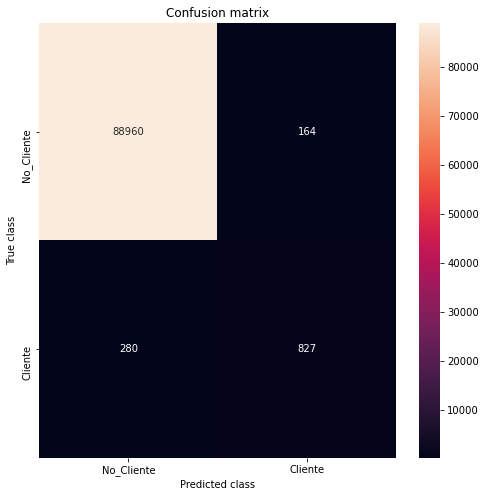

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89124
           1       0.83      0.75      0.79      1107

    accuracy                           1.00     90231
   macro avg       0.92      0.87      0.89     90231
weighted avg       0.99      1.00      0.99     90231



In [40]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [41]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [42]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
1A_EMPCONSUL_EST_NI,14.230808
FICH_PROMO_TOT,5.134286
BONDAD_EMAIL,5.043190
CANAL_REGISTRO_5,2.724559
TIPOEMAIL_TEMPORAL,2.554537
1A_EMPCONSUL_SECTOR_QUINARIO,2.506134
FECHA_REGISTRO_MONTH_11,2.159495
CANAL_REGISTRO_8,2.152168
FECHA_REGISTRO_MONTH_5,2.085826
FECHA_REGISTRO_MONTH_4,2.073305


In [43]:
feature_importances[feature_importances['important'] > 0.01].shape

(39, 1)

------

##### **4.4.3 Combinamos OverSampling con Subsampling**

**Combinando SMOTE & RandomUnderSampler**

In [44]:
over = SMOTE(sampling_strategy = 0.3)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [45]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [46]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 207814, 1: 2724})
Distribution after resampling Counter({0: 124688, 1: 62344})


In [47]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [48]:
clf.fit(X_train_res, y_train_res)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

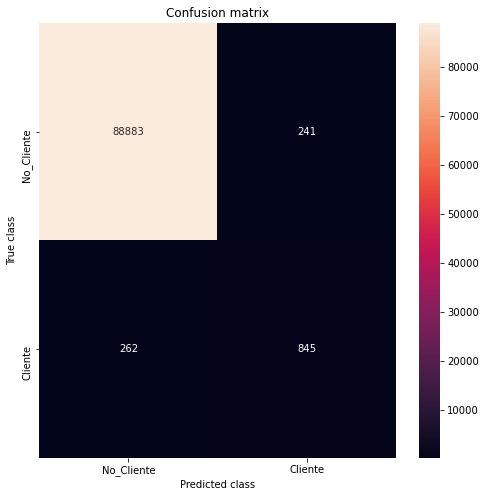

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89124
           1       0.78      0.76      0.77      1107

    accuracy                           0.99     90231
   macro avg       0.89      0.88      0.88     90231
weighted avg       0.99      0.99      0.99     90231



In [49]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [50]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [51]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
1A_EMPCONSUL_EST_NI,19.630194
BONDAD_EMAIL,13.162518
FICH_PROMO_TOT,4.178519
TIPOEMAIL_TEMPORAL,3.416345
1A_EMPCONSUL_SECTOR_QUINARIO,2.222006
FECHA_REGISTRO_MONTH_11,1.834336
IP_COUNTRY_PIB_Ingreso mediano alto,1.803174
FECHA_REGISTRO_MONTH_4,1.792352
FECHA_REGISTRO_MONTH_2,1.753099
CANAL_REGISTRO_5,1.650227


In [52]:
feature_importances[feature_importances['important'] > 0.01].shape

(31, 1)

------

**SMOTETomek**

In [44]:
os_us = SMOTETomek(sampling_strategy = 'all')
X_train_res, y_train_res = os_us.fit_resample(train_x, train_y)

In [45]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 207814, 1: 2724})
Distribution after resampling Counter({0: 207812, 1: 207812})


In [46]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [47]:
clf.fit(X_train_res, y_train_res)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

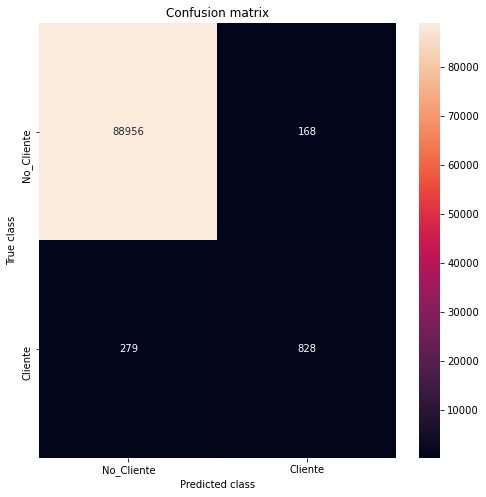

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89124
           1       0.83      0.75      0.79      1107

    accuracy                           1.00     90231
   macro avg       0.91      0.87      0.89     90231
weighted avg       0.99      1.00      0.99     90231



In [48]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [49]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [50]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
1A_EMPCONSUL_EST_NI,16.547098
TIPOEMAIL_TEMPORAL,5.229805
BONDAD_EMAIL,4.738715
FICH_PROMO_TOT,4.630390
CANAL_REGISTRO_5,3.597167
CANAL_REGISTRO_9,2.374861
1A_EMPCONSUL_SECTOR_QUINARIO,2.267224
FECHA_REGISTRO_MONTH_11,2.252545
CANAL_REGISTRO_8,2.141504
FECHA_REGISTRO_MONTH_4,2.095571


In [51]:
feature_importances[feature_importances['important'] > 0.01].shape

(34, 1)